In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

import community


from sklearn import linear_model
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
data = Path().absolute()/'data'

## Importando dados de citação

In [3]:
desapro_df = pd.read_csv(data/'citacoes_desapropriacao.csv')

In [4]:
desapro_df.shape

(108, 21)

Removing Sumulas

In [5]:
desapro_df.query('~ @desapro_df.caso.str.contains("sumula")',
                 engine='python', inplace=True)

In [6]:
print(desapro_df.sort_values('citacoes_total', ascending=False)[['caso','citacoes_total']].head(8))

         caso  citacoes_total
4    adi 2332              14
3    adi 2260               8
58  re 543974               8
37  re 172816               7
78   re 82300               5
64  re 635336               5
47  re 247866               5
65   re 64559               5


In [7]:
desapro_df.groupby('citacoes_total').size().to_frame()

,0
citacoes_total,
2,64
3,15
4,6
5,4
7,1
8,2
14,1


## Carregando Grafo

In [8]:
desapro_graph = nx.read_graphml(str(data.parent/'grafo_desapropriacao.graphml'))

### Gerando gráfico com a distribuição dos graus

Gráfico de In Degree

In [9]:
in_degree = pd.Series(dict(desapro_graph.in_degree), name='Número de Citações Recebidas').reset_index()

In [10]:
in_d_dist = in_degree.groupby('Número de Citações Recebidas').index.nunique().reset_index()

in_d_dist.rename(columns={'index': 'Número de Casos'}, inplace=True)

In [11]:
in_d_dist.head()

,Número de Citações Recebidas,Número de Casos
0,0,3973
1,1,218
2,2,113
3,3,57
4,4,48


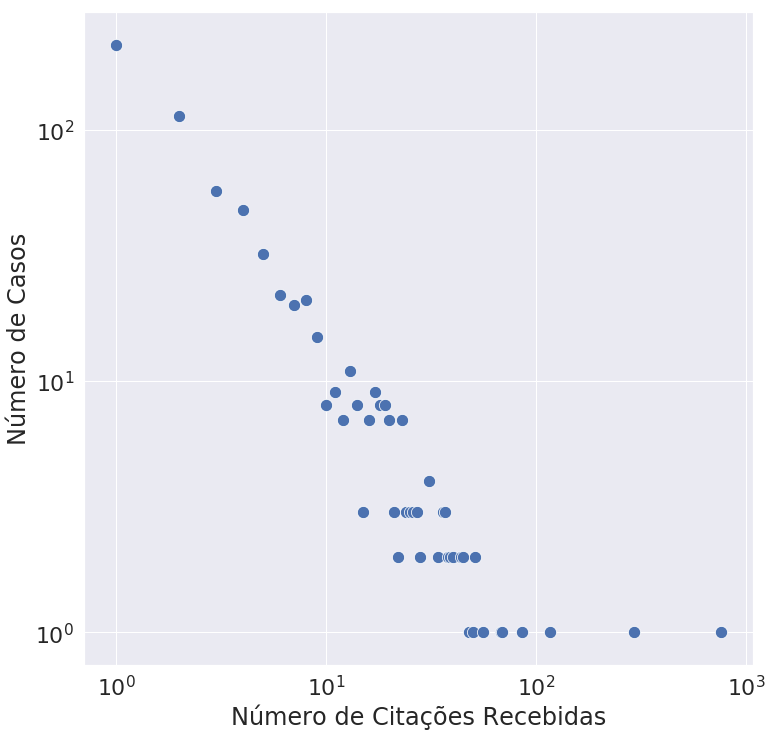

In [12]:
sns.set(rc={'figure.figsize':(12,12)}, font_scale=2)

fig, ax = plt.subplots(figsize=(12,12))

plt.xscale('log')
plt.yscale('log')

in_degree_graph = sns.scatterplot(x='Número de Citações Recebidas', y='Número de Casos', data=in_d_dist.drop(0), s=150,)

In [13]:
fig.savefig('graficos/in_desapropriacao.png')

Gráfico de Out Degree

In [14]:
out_degree = pd.Series(dict(desapro_graph.out_degree), name='Número de Citações Realizadas').reset_index()

In [15]:
out_d_dist = out_degree.groupby('Número de Citações Realizadas').index.nunique().reset_index()

out_d_dist.rename(columns={'index': 'Número de Casos'}, inplace=True)

In [16]:
out_d_dist.head()

,Número de Citações Realizadas,Número de Casos
0,0,2213
1,1,1328
2,2,417
3,3,185
4,4,214


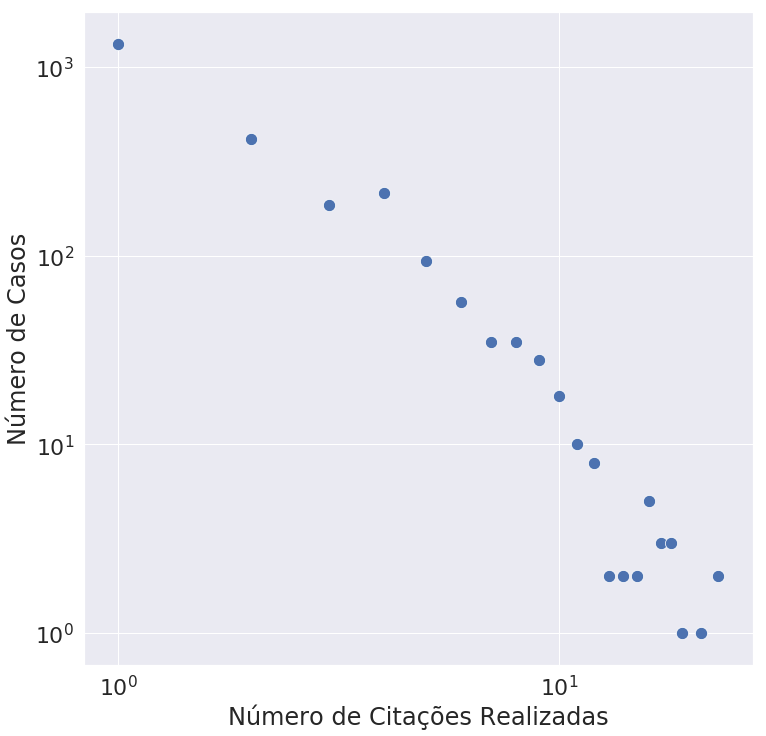

In [17]:
sns.set(rc={'figure.figsize':(12,12)}, font_scale=2)

fig, ax = plt.subplots(figsize=(12,12))

plt.xscale('log')
plt.yscale('log')

in_degree_graph = sns.scatterplot(x='Número de Citações Realizadas', y='Número de Casos', data=out_d_dist.drop(0), s=150,)

In [18]:
fig.savefig('graficos/out_desapropriacao.png')

### Removendo nós roxo - comunidade relativa ao RE 453740 que trata de juros para remuneração de servidores públicos

In [19]:
other_nodes = [n for n,v in desapro_graph.nodes(data=True) if v['Modularity Class'] != 1774]

In [20]:
len(other_nodes)

3903

In [21]:
graph = desapro_graph.subgraph(other_nodes)

### Calculando PageRank e HITS

In [22]:
pr_d = pd.Series(nx.algorithms.link_analysis.pagerank(graph),
                 name='page_rank').to_frame()

In [23]:
hub, auth = nx.algorithms.link_analysis.hits(graph)

In [24]:
hub_d = pd.Series(hub, name='hub_score').to_frame()

auth_d = pd.Series(auth, name='auth_score').to_frame()

Adicionando Modularidade

In [25]:
mod_d = pd.Series(nx.get_node_attributes(graph, 'Modularity Class'),
                  name='modularity').to_frame()

Obtendo número de citações

In [26]:
n_cit = pd.Series(nx.get_node_attributes(graph, 'In-Degree'),
                  name='n_citacoes').to_frame()

Gerando Dataframe com todas as informações

In [27]:
desaprop_info = mod_d.join(n_cit).join(pr_d).join(auth_d).join(hub_d)

In [28]:
desaprop_info.index = desaprop_info.index.str.lower()

Incluindo MARC In-degree

In [29]:
desaprop_info['marc'] = 1 + np.log2(desaprop_info['n_citacoes'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


In [30]:
desaprop_info.head()

,modularity,n_citacoes,page_rank,auth_score,hub_score,marc
ac 1132,697,0,0.000155,0.000000e+00,9.775919e-07,-inf
ac 1176,436,1,0.000286,1.399016e-135,0.000000e+00,1.000000
ac 1516,736,0,0.000155,0.000000e+00,1.217640e-137,-inf
ac 1546,751,3,0.000418,1.350715e-05,1.094673e-08,2.584963
ac 1577,1560,0,0.000155,0.000000e+00,0.000000e+00,-inf


substituindo infinitos por 0

In [31]:
desaprop_info.replace(-np.inf, 0, inplace=True)

#### Gerando Quantis para cada coluna

In [32]:
for c in desaprop_info[['page_rank', 'auth_score', 'hub_score']].columns:
    desaprop_info[c + '_quantile'] = pd.qcut(desaprop_info[c], 1000, duplicates='drop', labels=False)/10

### Juntando informação de citação com as medidas de rede

In [33]:
desaprop_info.index.name = 'caso'
desaprop_info.reset_index(drop=False, inplace=True)

In [34]:
desaprop_info.shape

(3903, 10)

In [35]:
desapro_df = desapro_df.merge(desaprop_info, how='right')

In [36]:
desapro_df[['citado', 'page_rank']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3903 entries, 0 to 3902
Data columns (total 2 columns):
citado       22 non-null float64
page_rank    3903 non-null float64
dtypes: float64(2)
memory usage: 91.5 KB


In [37]:
desapro_df.fillna(0, inplace=True)

Linear Model

In [38]:
y_d1 = desapro_df.page_rank_quantile
y_d2 = desapro_df.auth_score_quantile

x_d = desapro_df.citacoes_total

x_d = sm.add_constant(x_d, False)

In [39]:
linmodel_d_pr = sm.OLS(y_d1, x_d, missing='drop').fit()
linmodel_d_pr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     page_rank_quantile   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     62.52
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           3.41e-15
Time:                        15:30:24   Log-Likelihood:                -9839.4
No. Observations:                3903   AIC:                         1.968e+04
Df Residuals:                    3901   BIC:                         1.970e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
citacoes_total     1.1394      0.144      7.907      0.000       0.857       1.422
const              1.1206      0.048     23.213      0.000       1.026       1.215
==============================================================================
Omnibus:                     2232.421   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13502.521
Skew:                           2.830   Prob(JB):                         0.00
Kurtosis:                      10.141   Cond. No.                         2.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
linmodel_d_pr = sm.OLS(y_d2, x_d, missing='drop').fit()
linmodel_d_pr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     auth_score_quantile   R-squared:                       0.010
Model:                             OLS   Adj. R-squared:                  0.010
Method:                  Least Squares   F-statistic:                     39.75
Date:                 Mon, 19 Nov 2018   Prob (F-statistic):           3.20e-10
Time:                         15:30:24   Log-Likelihood:                -10424.
No. Observations:                 3903   AIC:                         2.085e+04
Df Residuals:                     3901   BIC:                         2.087e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
citacoes_total     1.0556      0.167      6.305      0.000       0.727       1.384
const              1.2874      0.056     22.955      0.000       1.177       1.397
==============================================================================
Omnibus:                     2158.370   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11946.218
Skew:                           2.756   Prob(JB):                         0.00
Kurtosis:                       9.563   Cond. No.                         2.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


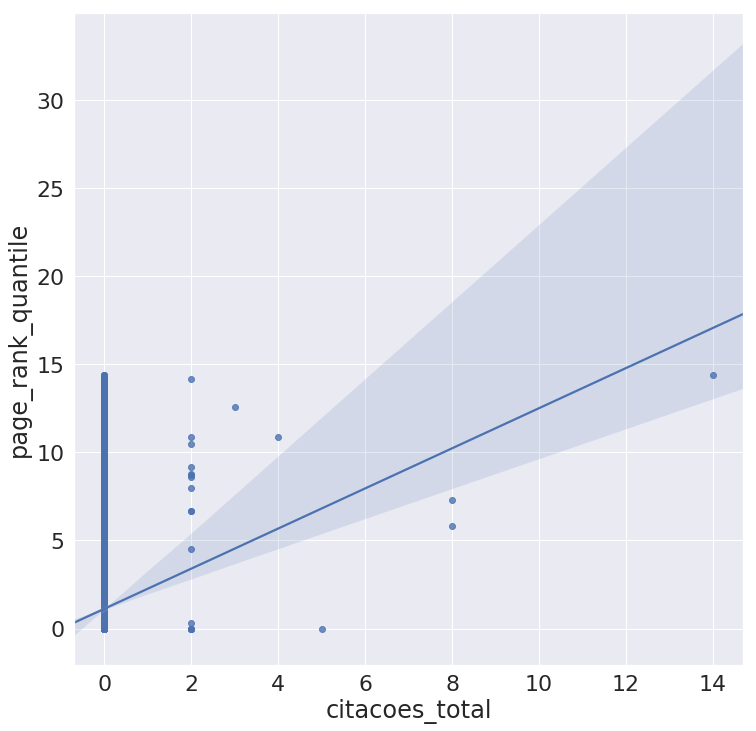

In [41]:
sns.regplot(x='citacoes_total', y='page_rank_quantile', data=desapro_df)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


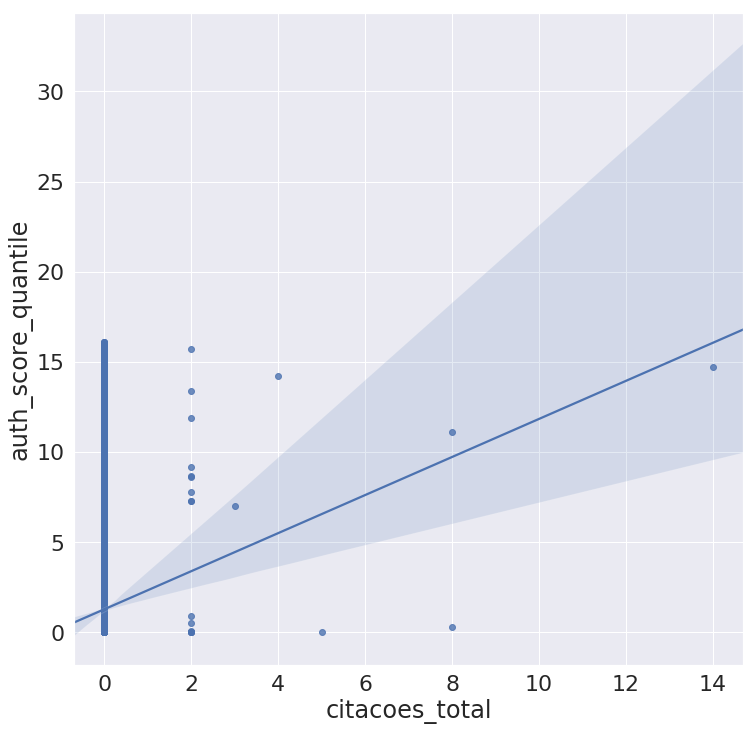

In [42]:
sns.regplot(x='citacoes_total', y='auth_score_quantile', data=desapro_df)

### Modelo Logístico

testando modelo com todas as varíavais

In [43]:
X = desapro_df[['page_rank_quantile', 'auth_score_quantile', 'hub_score_quantile', 'n_citacoes']]
X = sm.add_constant(X)

logit_model = sm.Logit(exog=X,
                       endog=desapro_df['citado'])

logit_result = logit_model.fit(disp=False)

In [44]:
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 citado   No. Observations:                 3903
Model:                          Logit   Df Residuals:                     3898
Method:                           MLE   Df Model:                            4
Date:                Mon, 19 Nov 2018   Pseudo R-squ.:                  0.1554
Time:                        15:30:27   Log-Likelihood:                -114.75
converged:                       True   LL-Null:                       -135.86
                                        LLR p-value:                 1.493e-08
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.7807      0.340    -16.992      0.000      -6.447      -5.114
page_rank_quantile      0.2105      0.063      3.340      0.001       0.087       0.334
auth_score_quantile     0.0623      0.061      1.022      0.307      -0.057       0.182
hub_score_quantile     -0.0542      0.026     -2.050      0.040      -0.106      -0.002
n_citacoes              0.0019      0.008      0.230      0.818      -0.014       0.018
=======================================================================================
"""

Testando modelo sem número de citações

In [45]:
X = desapro_df[['page_rank_quantile', 'auth_score_quantile', 'hub_score_quantile']]
X = sm.add_constant(X)

logit_model = sm.Logit(exog=X,
                       endog=desapro_df['citado'])

logit_result = logit_model.fit(disp=False)

logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 citado   No. Observations:                 3903
Model:                          Logit   Df Residuals:                     3899
Method:                           MLE   Df Model:                            3
Date:                Mon, 19 Nov 2018   Pseudo R-squ.:                  0.1552
Time:                        15:30:27   Log-Likelihood:                -114.77
converged:                       True   LL-Null:                       -135.86
                                        LLR p-value:                 3.668e-09
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.7872      0.340    -17.035      0.000      -6.453      -5.121
page_rank_quantile      0.2129      0.062      3.442      0.001       0.092       0.334
auth_score_quantile     0.0646      0.060      1.084      0.279      -0.052       0.181
hub_score_quantile     -0.0545      0.026     -2.063      0.039      -0.106      -0.003
=======================================================================================
"""

Comando para exportar tabela em latex

In [46]:
# print(logit_result.summary().as_latex())

## Testes

In [47]:
X = desapro_df[['page_rank_quantile', 'auth_score_quantile', 'hub_score_quantile', 'n_citacoes', 'marc']]
X = sm.add_constant(X)

logit_model = sm.Logit(exog=X,
                       endog=desapro_df['citado'])

logit_result4 = logit_model.fit(disp=False)

logit_result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 citado   No. Observations:                 3903
Model:                          Logit   Df Residuals:                     3897
Method:                           MLE   Df Model:                            5
Date:                Mon, 19 Nov 2018   Pseudo R-squ.:                  0.1652
Time:                        15:30:28   Log-Likelihood:                -113.42
converged:                       True   LL-Null:                       -135.86
                                        LLR p-value:                 1.531e-08
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.8161      0.346    -16.806      0.000      -6.494      -5.138
page_rank_quantile      0.0460      0.129      0.357      0.721      -0.206       0.298
auth_score_quantile     0.0173      0.069      0.250      0.803      -0.119       0.153
hub_score_quantile     -0.0599      0.028     -2.132      0.033      -0.115      -0.005
n_citacoes             -0.0081      0.012     -0.675      0.500      -0.031       0.015
marc                    0.5627      0.356      1.580      0.114      -0.135       1.261
=======================================================================================
"""

In [48]:
X = desapro_df[['hub_score_quantile', 'marc']]
X = sm.add_constant(X)

logit_model = sm.Logit(exog=X,
                       endog=desapro_df['citado'])

logit_result3 = logit_model.fit(disp=False)

logit_result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 citado   No. Observations:                 3903
Model:                          Logit   Df Residuals:                     3900
Method:                           MLE   Df Model:                            2
Date:                Mon, 19 Nov 2018   Pseudo R-squ.:                  0.1606
Time:                        15:30:29   Log-Likelihood:                -114.04
converged:                       True   LL-Null:                       -135.86
                                        LLR p-value:                 3.340e-10
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.7336      0.327    -17.518      0.000      -6.375      -5.092
hub_score_quantile    -0.0568      0.027     -2.101      0.036      -0.110      -0.004
marc                   0.6306      0.087      7.211      0.000       0.459       0.802
======================================================================================
"""

In [49]:
# sns.regplot(x='page_rank_quantile', y='citado', data=desapro_df, fit_reg=True, logistic=True)